## Motivation  

Throughout most of our experiments, we stain our embryos for the markers NANOG (epiblast) and GATA6 (primitive endoderm). Normally we use the same antibodies to detect them, a rabbit anti-NANOG and a goat anti-GATA6, widely used in the field (details in Table 3 of the paper). However, in certain instances, due to incompatibility with other antibodies in the same mix, we use alternative ones: a rat anti-NANOG and a rabbit anti-GATA6 (see Table 3 for details). In order to simplify our analysis, we wanted to transform the fluorescence intensity values obtained with these alternative antibodies (NANOG (rat) and GATA6 (rb)) to values equivalent to our typical antibodies (NANOG (rb) and GATA6 (gt)).  

To do that, we co-stained a subset of embryos at different stages of development for either:
* NANOG (rb) + NANOG (rat) and GATA6 (gt) as a counterstain, or
* GATA6 (gt) + GATA6 (rb) and NANOG (rat) as a counterstain  

We used the data from these embryos to fit linear regression models comparing levels of NANOG obtained with both antibodies and levels of GATA6 obtained with both antibodies.  

### Set up  

Load R packages we will need and preset some asthetics for plotting

In [4]:
library('reshape2')
library('plyr')
library('dplyr')
library('ggplot2')

looks <- theme_bw() + theme(panel.grid = element_blank(), 
                            strip.background = element_blank(), 
                            panel.border = element_rect(color = 'black', 
                                                        size = 1), 
                            axis.ticks = element_line(color = 'black', 
                                                      size = 0.5), 
                            axis.text = element_text(size = 6, 
                                                     color = 'black'), 
                            axis.title = element_text(size = 8, 
                                                      color = 'black'), 
                            legend.text = element_text(size = 8, 
                                                       color = 'black'), 
                            legend.title = element_text(size = 10, 
                                                        color = 'black'), 
                            strip.text = element_text(size = 8, 
                                                      color = 'black'))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


### Load data and run code to do the modeling  

Load the staining data, already corrected for Z-axis decay, using the script ```ab-test.R``` found in ```./src/ab-test.R```. The transformation code is ommited here but can be found in the repository.

In [5]:
abtest <- read.csv('../data/interim/abtest.csv')

Below is the last part of ```ab-test.R``` where we fit the model, which is trivial:

In [6]:
# Run the function find-pairs.R to establish the 
# pairs of antibodies and embryos to use in the models.
# Its otput is ab.pairs
source('../src/find-pairs.R')
find.pairs(abtest)

# Subset embryos stained with both NANOG antibodies and exclude 
# data from 050617, as it deviates notably from the other five experiments
ng.all <- subset(abtest, Experiment %in% ab.pairs[[1]][[2]][
        which(ab.pairs[[1]][[2]] != "050617NGvNG")])

# Subset embryos stained with both GATA6 antibodies
gatas <- subset(abtest, Experiment %in% ab.pairs[[2]][[2]])

# Fit a linear model to the NANOG stainings
ng.model <- lm(ng.all$CH2.ebLogCor ~ ng.all$CH3.ebLogCor)
# Fit a linear model to the GATA6 stainings
gata.model <- lm(gatas$CH3.ebLogCor ~ gatas$CH5.ebLogCor)


### Visualize transformation of NANOG levels  

Plot levels of NANOG (rb) vs NANOG (rat) in ICM cells for all embryos, color coded for levels of GATA6 (gt) and overlaid with the regression line

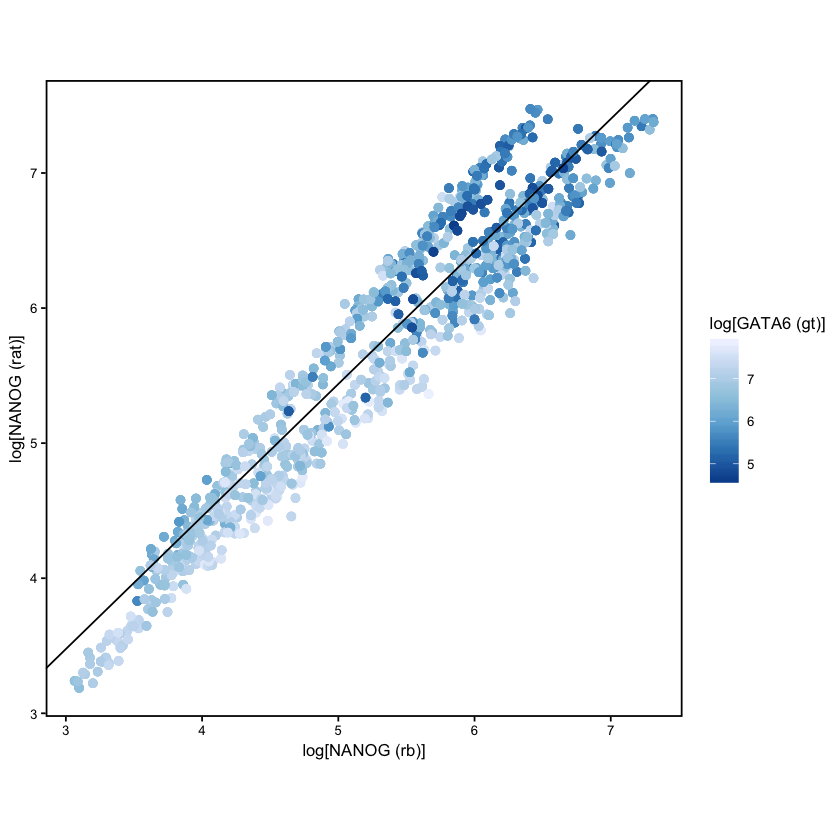

In [7]:
nnp1 <- ggplot(ng.all %>% filter(TE_ICM == 'ICM'), 
               aes(x = CH3.ebLogCor, y = CH2.ebLogCor)) + 
        geom_jitter(aes(color = CH5.ebLogCor), size = 2) + 
        geom_abline(intercept = ng.model$coefficients[1], 
                    slope = ng.model$coefficients[2]) + 
        looks + scale_color_distiller(palette = 'Blues') + 
        labs(x = 'log[NANOG (rb)]', y = 'log[NANOG (rat)]', 
             color = 'log[GATA6 (gt)]') + 
        theme(aspect.ratio = 1, axis.text = element_text(size = 8, color = 'black'), 
             axis.title = element_text(size = 10, color = 'black'))
print(nnp1)

Plot levels of NANOG (rb) vs NANOG (rat) in ICM cells **for each embryo**, color coded for levels of GATA6 (gt) and overlaid with the regression line, as above. Overlay the transformed levels of NANOG (rat) (in red) and a regression line of ```slope = 1``` and ```intercept = 0``` (red) to ilustrate the shift downward caused by the transformation.

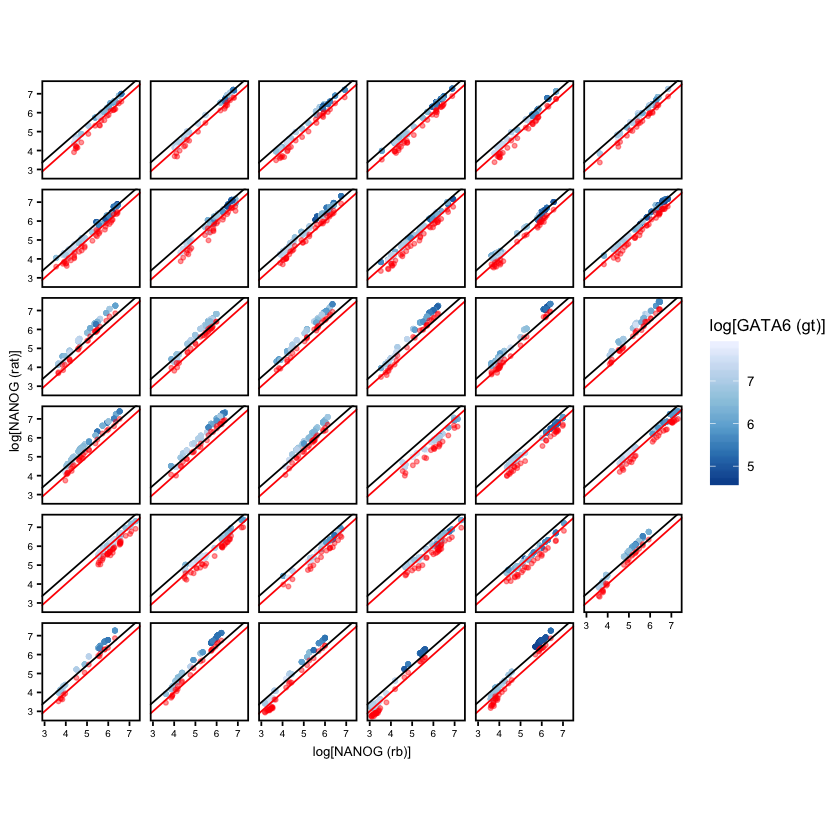

In [8]:
nnp2 <- ggplot(ng.all %>% filter(TE_ICM == 'ICM'), 
               aes(x = CH3.ebLogCor, y = CH2.ebLogCor)) + 
        geom_jitter(aes(color = CH5.ebLogCor), size = 1) + 
        geom_jitter(aes(x = CH3.ebLogCor, 
                        y = (CH2.ebLogCor - ng.model$coefficients[1])/
                                ng.model$coefficients[2]),
                    color = 'red', size = 1, alpha = 0.1) + 
        geom_abline(intercept = ng.model$coefficients[1], 
                    slope = ng.model$coefficients[2]) + 
        geom_abline(intercept = 0, slope = 1, color = 'red') + 
        looks + scale_color_distiller(palette = 'Blues') + 
        facet_wrap( ~ Embryo_ID, ncol = 6) + 
        theme(aspect.ratio = 1, strip.text.x = element_blank()) + 
        labs(x = 'log[NANOG (rb)]', y = 'log[NANOG (rat)]', 
             color = 'log[GATA6 (gt)]')
print(nnp2)

### Visualize transformation of GATA6 levels  

Likewise, plot levels of GATA6 (gt) vs GATA6 (rb) in ICM cells for all embryos, color coded for levels of NANOG (rat) and overlaid with the regression line

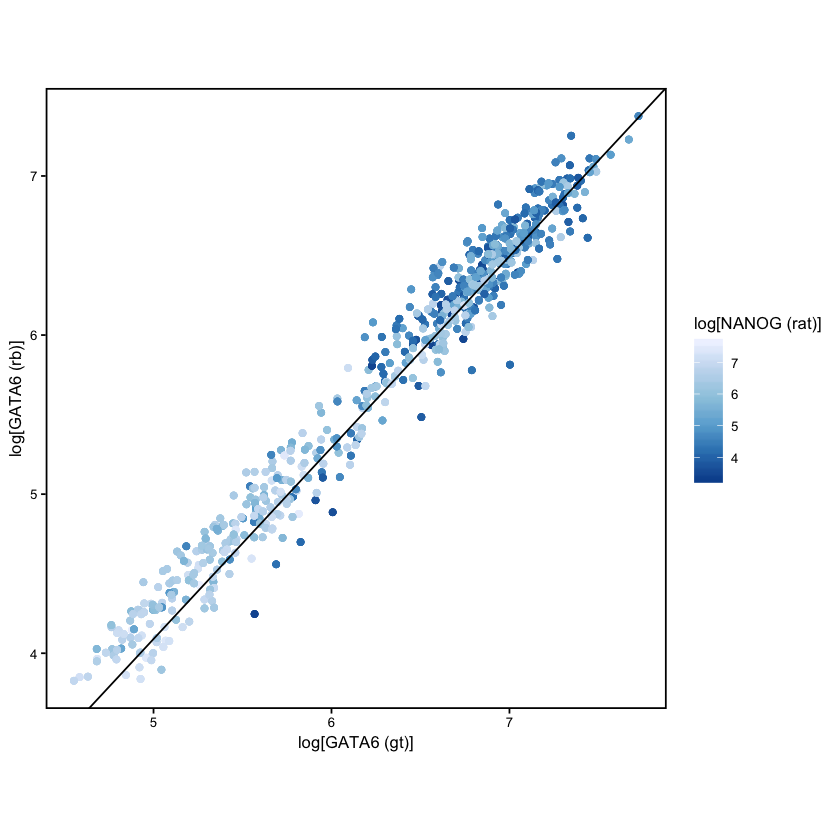

In [9]:
ggp1 <- ggplot(gatas %>% filter(TE_ICM == 'ICM'), 
               aes(x = CH5.ebLogCor, y = CH3.ebLogCor)) +
        geom_jitter(aes(color = CH2.ebLogCor)) + 
        geom_abline(intercept = gata.model$coefficients[1],
                    slope = gata.model$coefficients[2]) +
        looks + scale_color_distiller(palette = 'Blues') + 
        labs(x = 'log[GATA6 (gt)]', y = 'log[GATA6 (rb)]', 
             color = 'log[NANOG (rat)]') + 
        theme(aspect.ratio = 1, axis.text = element_text(size = 8, color = 'black'), 
             axis.title = element_text(size = 10, color = 'black'))
print(ggp1)

Plot levels of GATA6 (gt) vs GATA6 (rb) in ICM cells **for each embryo**, color coded for levels of NANOG (rat) and overlaid with the regression line, as above. Overlay the transformed levels of GATA6 (rb) (in red) and a regression line of ```slope = 1``` and ```intercept = 0``` (red) to ilustrate the shift upward caused by the transformation.

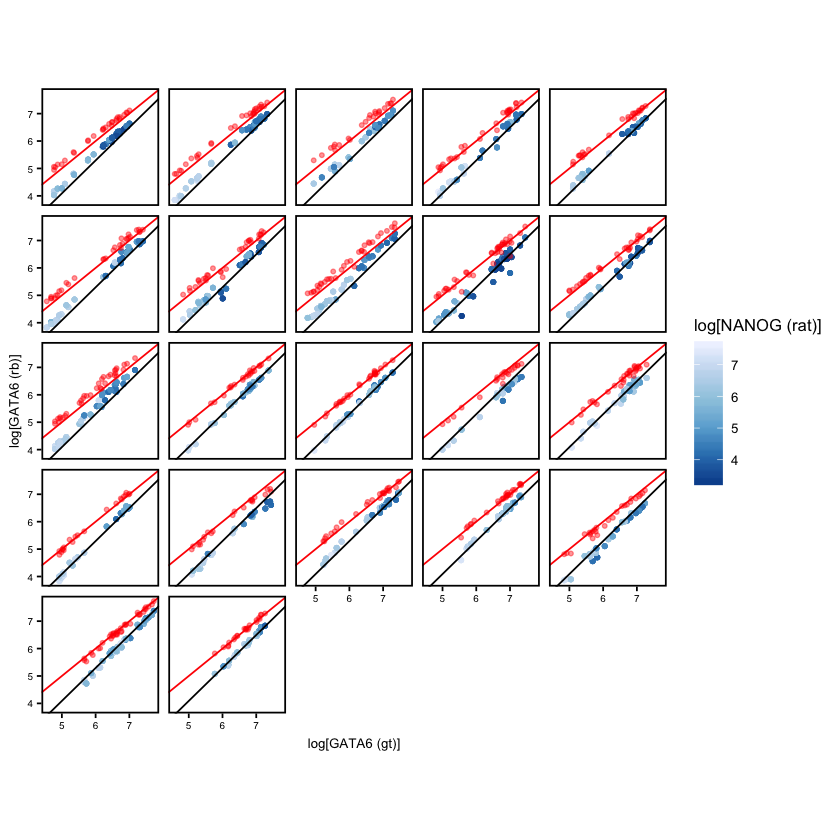

In [10]:
ggp2 <- ggplot(gatas %>% filter(TE_ICM == 'ICM'), 
               aes(x = CH5.ebLogCor, y = CH3.ebLogCor)) +
        geom_jitter(aes(color = CH2.ebLogCor), size = 1) + 
        geom_jitter(aes(x = CH5.ebLogCor, 
                        y = (CH3.ebLogCor - gata.model$coefficients[1])/
                                gata.model$coefficients[2]),
                    color = 'red', size = 1, alpha = 0.1) + 
        geom_abline(intercept = gata.model$coefficients[1],
                    slope = gata.model$coefficients[2]) +
        geom_abline(intercept = 0, slope = 1, color = 'red') + 
        looks + facet_wrap( ~ Embryo_ID, ncol = 5) + 
        scale_color_distiller(palette = 'Blues') + 
        theme(aspect.ratio = 1, strip.text.x = element_blank()) + 
        labs(x = 'log[GATA6 (gt)]', y = 'log[GATA6 (rb)]', 
             color = 'log[NANOG (rat)]')
print(ggp2)

### Compare transformed and untransformed subsets of data  

Let's look at the effect this transformation has in the data for the reference littermates shown in Supplementary Figures 1b, d and e of the paper, and which are described in the notebook ```Z-correction.ipynb```.  

Start out by loading the dataset:

In [29]:
new.lms <- read.csv('../data/interim/new-lms-tx.csv')

In [30]:
## Order levels of the Stage variable for plotting
new.lms$Stage <- factor(new.lms$Stage, levels = c('<8', '8_16', '16_32', '32_64', '64_90', 
                                                  '90_120', '120_150', '>150'))

And then run lines 143-149 of ```new-lms_tx.R```, which extract the markers used to stain each experiment

In [31]:
# Generate data frame containing the unique values 
# for the markers associated with channels 2, 3 and 5 in the new-lms dataset
unicos <- new.lms %>% filter(Channel %in% c('CH2', 'CH3', 'CH5')) %>% 
  group_by(Experiment, Treatment, Genotype1, Channel, Marker) %>% 
  summarize()
unicos <- dcast(unicos, Experiment + Treatment + Genotype1 ~ 
                  Channel, value.var = 'Marker')

Now create three subsets of data listing experiments stained for:
* NANOG (rb) and GATA6 (gt) - the most common case throughout the study
* NANOG (rat) and GATA6 (gt)
* NANOG (rat) and GATA6 (rb)

In [32]:
aa <- unicos$Experiment[which(unicos$CH3 == 'NANOG.rb' & unicos$CH5 == 'GATA6.gt')]
bb <- unicos$Experiment[which(unicos$CH2 == 'NANOG.rat' & unicos$CH5 == 'GATA6.gt')]
cc <- unicos$Experiment[which(unicos$CH2 == 'NANOG.rat' & unicos$CH3 == 'GATA6.rb')]

Plot the levels of GATA6 vs NANOG for each developmental stage, color coding for each of the three groups of experiments defined above.  

The data below are corrected for decay along the Z-axis, but NANOG and GATA6 values have not been transformed into NANOG(rb)- and GATA6(gt)-equivalents: 

In [33]:
## Data is repeated 5x, one per channel. Slim it down to one channel to speed up operations
new.lms <- filter(new.lms, Channel == 'CH2')

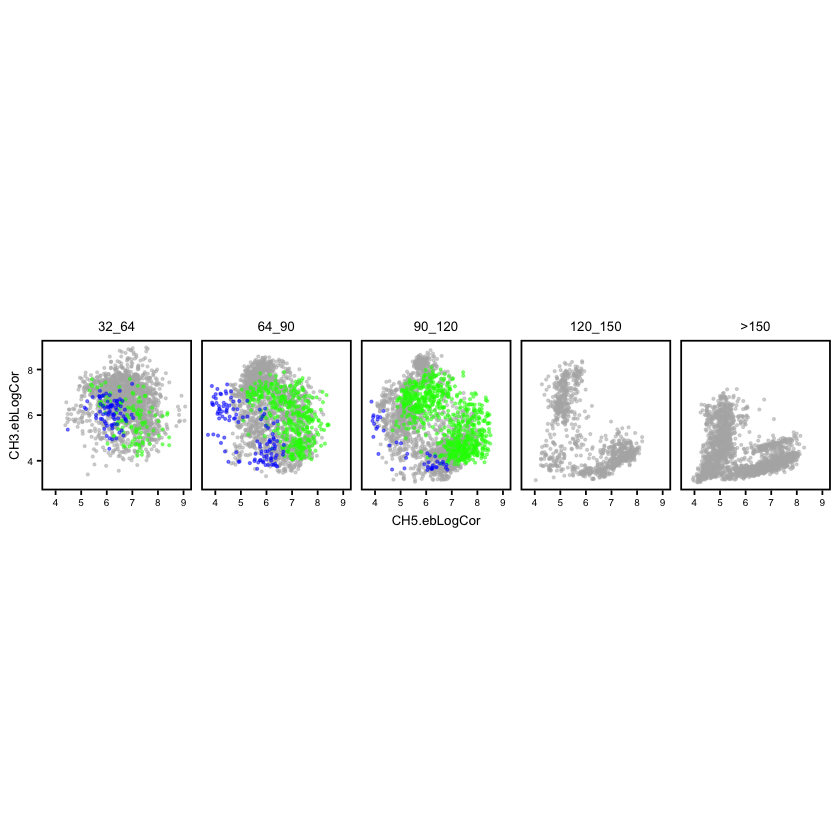

In [36]:
b4x <- ggplot(data = subset(new.lms, Experiment %in% aa & 
                            TE_ICM == 'ICM' & 
                            Cellcount > 31),
                   aes(x = CH5.ebLogCor, y = CH3.ebLogCor))
b4x <- b4x + geom_jitter(color = 'gray70', size = 0.5, alpha = 0.5) + 
        geom_jitter(data = subset(new.lms, Experiment %in% bb & 
                                  TE_ICM == 'ICM' & 
                                  Cellcount > 31),
                    aes(x = CH5.ebLogCor, y = CH2.ebLogCor), 
                    color = 'green', size = 0.5, alpha = 0.5) + 
        geom_jitter(data = subset(new.lms, Experiment %in% cc & 
                                  TE_ICM == 'ICM' & 
                                  Cellcount > 31), 
                    aes(x = CH3.ebLogCor, y = CH2.ebLogCor), 
                    color = 'blue', size = 0.5, alpha = 0.5)
b4x <- b4x + facet_grid(. ~ Stage) + 
        looks +
        theme(aspect.ratio = 1) +
        ylim(3, 9)
print(b4x)

* NANOG (rb) and GATA6 (gt) are shown in grey (these data do not get transformed)
* NANOG (rat) and GATA6 (gt) are shown in green 
* NANOG (rat) and GATA6 (rb) are shown in blue 

The plot below shows the same data, after transforming NANOG and GATA6 levels to NANOG(rb)- and GATA6(gt)-equivalent. Note that the only difference in the code is that ```x = CH5.ebLogCor.x``` and ```y = CH3.ebLogCor.x``` for all datasets. 

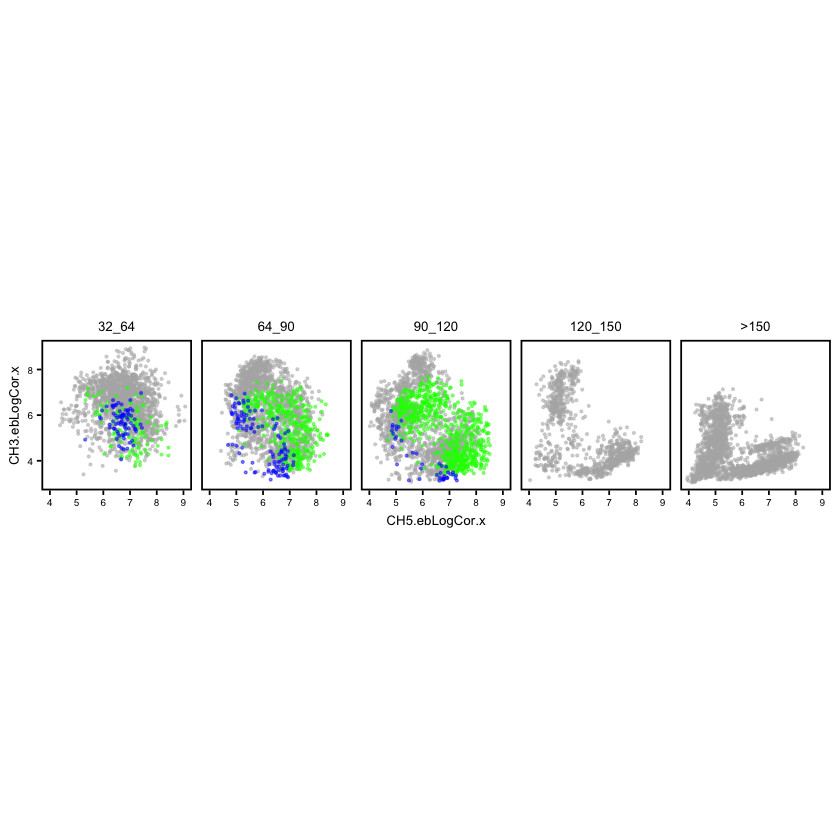

In [37]:
after.x <- ggplot(data = subset(new.lms, Experiment %in% aa & 
                            TE_ICM == 'ICM' & 
                            Cellcount > 31),
                   aes(x = CH5.ebLogCor.x, y = CH3.ebLogCor.x))
after.x <- after.x + geom_jitter(color = 'gray70', size = 0.5, alpha = 0.5) + 
        geom_jitter(data = subset(new.lms, Experiment %in% bb & 
                                  TE_ICM == 'ICM' & 
                                  Cellcount > 31),
                    aes(x = CH5.ebLogCor.x, y = CH3.ebLogCor.x), 
                    color = 'green', size = 0.5, alpha = 0.5) + 
        geom_jitter(data = subset(new.lms, Experiment %in% cc & 
                                  TE_ICM == 'ICM' & 
                                  Cellcount > 31), 
                    aes(x = CH5.ebLogCor.x, y = CH3.ebLogCor.x), 
                    color = 'blue', size = 0.5, alpha = 0.5)
after.x <- after.x + facet_grid(. ~ Stage) + 
        looks +
        theme(aspect.ratio = 1) +
        ylim(3, 9)
print(after.x)

The shift in the green and blue populations is minor, but nonetheless brings all values closer and reduces technical noise in the data